<a href="https://colab.research.google.com/github/sami-abd/Machine-Learning-Vegetable-Classifier/blob/main/vegetableclassifierCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imshow
from skimage.transform import resize
from tensorflow.keras import datasets, layers, models
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn import preprocessing

In [ ]:
#unzip the dataset
!unzip VegetablesDataset.zip


In [ ]:
#img_dir is where subdirectories of images are located, and fraction is x in 1/x images to include in set
def create_set(img_dir, fraction):
  # Create empty lists for images and classes
  images = []
  classes = []

  skip = 0
  directory_counter = 0

  # Loop through the subdirectories in the given directory
  for category in os.listdir(img_dir):
    # Get the path to the subdirectory
    path = os.path.join(img_dir, category)
    # Loop through the files in the subdirectory
    for filename in os.listdir(path):
      # Read and resize the image if the skip counter is 0
      if (skip == 0):
        # Read the image in RGB format
        image = plt.imread(os.path.join(path, filename))
        # Check that the image was read successfully
        if np.any(image):
          # Resize and normalize the images
          image = resize(image, (224,224), mode='constant')
          #append the images and classes to the lists
          images.append(image)
          classes.append(category)

      # Increment the skip counter
      skip = (skip + 1) % fraction
    #increment the directory counter  
    directory_counter += 1
    print("Completed resizing and normalizing of 1/" + str(fraction) +" of the images in the " + category + " category in the" + "\"" + img_dir + " \" directory. " + str(directory_counter) +"/"+ str(len(os.listdir(img_dir))) + ".")
  # Return the list of images and classes as numpy arrays
  return np.array(images), np.array(classes)


In [ ]:
#save the vegetable class names
classnames = os.listdir("/content/Vegetable Images/train")
print(classnames)

#save the training image data and classes
train_images, train_classes = create_set("/content/Vegetable Images/train", 5)

#save the test image data and classes
test_images, test_classes = create_set("/content/Vegetable Images/test", 5)

#save the validation image data and classes
validation_images, validation_classes = create_set("/content/Vegetable Images/validation", 5)



['Cauliflower', 'Brinjal', 'Radish', 'Tomato', 'Cabbage', 'Potato', 'Carrot', 'Bottle_Gourd', 'Broccoli', 'Capsicum', 'Cucumber', 'Pumpkin', 'Bean', 'Papaya', 'Bitter_Gourd']
Completed resizing and normalizing of 1/5 of the images in the Cauliflower category in the"/content/Vegetable Images/train " directory. 1/15.
Completed resizing and normalizing of 1/5 of the images in the Brinjal category in the"/content/Vegetable Images/train " directory. 2/15.
Completed resizing and normalizing of 1/5 of the images in the Radish category in the"/content/Vegetable Images/train " directory. 3/15.
Completed resizing and normalizing of 1/5 of the images in the Tomato category in the"/content/Vegetable Images/train " directory. 4/15.
Completed resizing and normalizing of 1/5 of the images in the Cabbage category in the"/content/Vegetable Images/train " directory. 5/15.
Completed resizing and normalizing of 1/5 of the images in the Potato category in the"/content/Vegetable Images/train " directory. 6/

In [ ]:

#set a seed for repeatablity
np.random.seed(seed=0)

#permute the sequence in the dataset and use it to reorganize the data
Randomized_Indices = np.random.permutation(train_images.shape[0])
train_images = train_images[Randomized_Indices]
train_classes = train_classes[Randomized_Indices] 
print(train_classes)


['Brinjal' 'Potato' 'Bottle_Gourd' ... 'Broccoli' 'Papaya' 'Papaya']


(3000, 224, 224, 3)
0.0 1.0


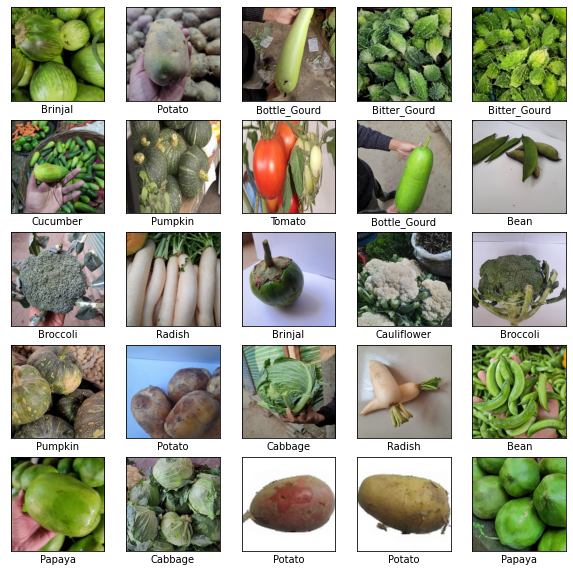

In [ ]:
#Plotting the images and classes
print(train_images.shape)
print(train_images.min(), train_images.max())
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow((train_images[i]))
    plt.xlabel(train_classes[i])
plt.show()

In [ ]:
# Convert all the classes to integers
classes_encoder = preprocessing.LabelEncoder()
classes_encoder.fit(classnames)

# Encode the training validation and test classes into one hot form
train_classes_encoded = classes_encoder.transform(train_classes)
train_onehot = tf.one_hot(train_classes_encoded, 15)

validation_classes_encoded = classes_encoder.transform(validation_classes)
validation_onehot = tf.one_hot(validation_classes_encoded, 15)

test_classes_encoded = classes_encoder.transform(test_classes)

In [ ]:
# Create the convolutional base
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Add dense layers on top
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(15, activation='softmax'))


In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 173056)            0

In [ ]:
#Compile and train the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

with tf.device('/device:GPU:0'):
  history = model.fit(train_images, train_onehot, epochs=20, 
                    validation_data=(validation_images, validation_onehot))

Epoch 1/20
94/94 [==============================] - 17s 75ms/step - loss: 2.5375 - accuracy: 0.1723 - val_loss: 2.1609 - val_accuracy: 0.2900
Epoch 2/20
94/94 [==============================] - 6s 63ms/step - loss: 1.9593 - accuracy: 0.3443 - val_loss: 1.5469 - val_accuracy: 0.5167
Epoch 3/20
94/94 [==============================] - 6s 62ms/step - loss: 1.5799 - accuracy: 0.4770 - val_loss: 1.1984 - val_accuracy: 0.6550
Epoch 4/20
94/94 [==============================] - 6s 63ms/step - loss: 1.2508 - accuracy: 0.5643 - val_loss: 1.0433 - val_accuracy: 0.6717
Epoch 5/20
94/94 [==============================] - 7s 74ms/step - loss: 1.1210 - accuracy: 0.6157 - val_loss: 1.1214 - val_accuracy: 0.6417
Epoch 6/20
94/94 [==============================] - 7s 72ms/step - loss: 0.9804 - accuracy: 0.6630 - val_loss: 0.9258 - val_accuracy: 0.7083
Epoch 7/20
94/94 [==============================] - 6s 63ms/step - loss: 0.8464 - accuracy: 0.6980 - val_loss: 0.8229 - val_accuracy: 0.7400
Epoch 8/20
9

19/19 - 1s - loss: 1.0612 - accuracy: 0.7633 - 524ms/epoch - 28ms/step


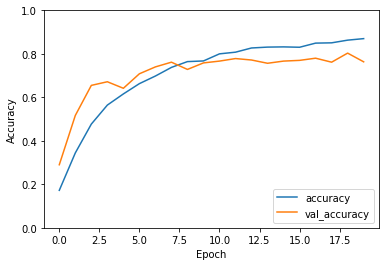

In [ ]:
#evaluate the model

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(validation_images, validation_onehot, verbose=2)

19/19 - 1s - loss: 1.0612 - accuracy: 0.7633 - 502ms/epoch - 26ms/step


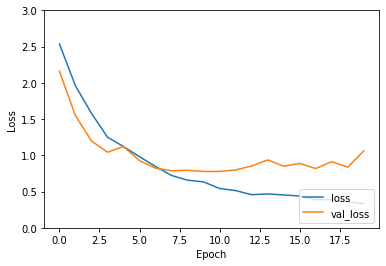

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 3])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(validation_images, validation_onehot, verbose=2)

In [ ]:
#defining a function to compute the confusion matrix and accuracy
def compute_confusion_matrix(true, pred):
  K = len(np.unique(true)) #number of classes
  result = np.zeros((K, K))
  for i in range(len(true)):
    result[true[i]][pred[i]] += 1
  
  # Calculate the accuracy by summing the diagonal elements of the confusion matrix and dividing by the total number of samples
  for x in range(K):
    accuracy = np.sum(np.diagonal(result))*100 / len(true)
  return result, accuracy

In [ ]:

#testing the model:

# Predict class probabilities for test images using the model
test_classes_pred = model.predict(test_images)

# Find the class with the highest probability for each test image
# by finding the index of the maximum value along axis 1
test_classes_pred = np.argmax(test_classes_pred, axis=1) 

# Compute and display the confusion matrix and accuracy
confusion_mx_acc = compute_confusion_matrix(test_classes_encoded, test_classes_pred)

print("Confusion matrix: ")
print(confusion_mx_acc[0])

print("Accuracy: "+ str(confusion_mx_acc[1]) + "%")

In [ ]:
# #testing own images:

#create path and use original create_set function to convert images into appropriate
#lists
path = "/content/Personal Vegetable Images"
personal_test_images, personal_test_classes = create_set(path, 1)

#model predicts using personal images
predictions_personal_onehot = model.predict(personal_test_images)

# Find the class with the highest probability for each personal image
# by finding the index of the maximum value along axis 1
predictions_personal = np.argmax(predictions_personal_onehot, axis=1)


Completed resizing and normalizing of 1/1 of the images in the Cauliflower category in the"/content/Personal Vegetable Images " directory. 1/11.
Completed resizing and normalizing of 1/1 of the images in the .ipynb_checkpoints category in the"/content/Personal Vegetable Images " directory. 2/11.
Completed resizing and normalizing of 1/1 of the images in the Tomato category in the"/content/Personal Vegetable Images " directory. 3/11.
Completed resizing and normalizing of 1/1 of the images in the Cabbage category in the"/content/Personal Vegetable Images " directory. 4/11.
Completed resizing and normalizing of 1/1 of the images in the Potato category in the"/content/Personal Vegetable Images " directory. 5/11.
Completed resizing and normalizing of 1/1 of the images in the Carrot category in the"/content/Personal Vegetable Images " directory. 6/11.
Completed resizing and normalizing of 1/1 of the images in the Broccoli category in the"/content/Personal Vegetable Images " directory. 7/11.


Prediction: Broccoli    Actual: Cauliflower
Prediction: Bitter_Gourd    Actual: Tomato
Prediction: Potato    Actual: Cabbage
Prediction: Pumpkin    Actual: Potato
Prediction: Pumpkin    Actual: Carrot
Prediction: Cauliflower    Actual: Broccoli
Prediction: Carrot    Actual: Capsicum
Prediction: Broccoli    Actual: Cucumber
Prediction: Bitter_Gourd    Actual: Pumpkin
Prediction: Cauliflower    Actual: Bean


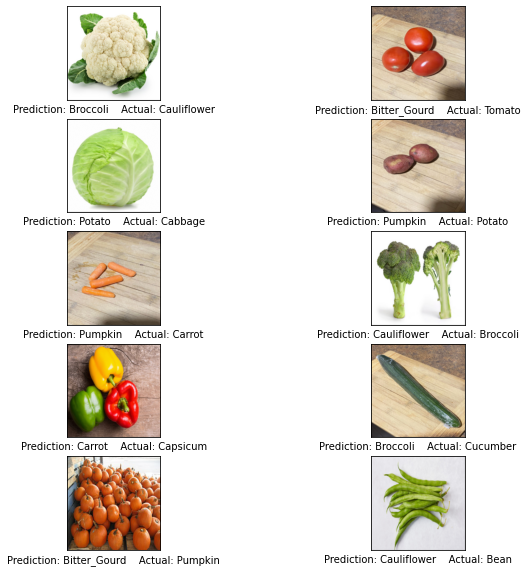

In [ ]:
#Plotting the predictions of the images and classes

plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(personal_test_images[i])
    plt.xlabel("Prediction: " + str(classnames[predictions_personal[i]]) + "    Actual: " + personal_test_classes[i])
    print("Prediction: " + str(classnames[predictions_personal[i]]) + "    Actual: " + personal_test_classes[i])
plt.show()